Reference:

https://github.com/Gurupradeep/FCN-for-Semantic-Segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np

from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

Using TensorFlow backend.


In [0]:
from __future__ import print_function

import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, models
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from skimage.io import imsave
import cv2
from keras.preprocessing.image import ImageDataGenerator

In [0]:
x_test_path = '/content/drive/My Drive/Colab Notebooks/Test/original_retinal_images/'
y_test_path = '/content/drive/My Drive/Colab Notebooks/Test/blood_vessel_segmentation_masks/'

In [0]:
def read_data(path):
    image_names = sorted(os.listdir(path))
    #print(image_names)
    l = []
    for i in range(len(image_names)):
        tmp = cv2.imread(path + image_names[i], 0)
        l.append(tmp)

    return np.asanyarray(l)

In [6]:
x_test = read_data(x_test_path) / 255
y_test = read_data(y_test_path) / 255

x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=3)

x_test.shape, y_test.shape

((20, 512, 512, 1), (20, 512, 512, 1))

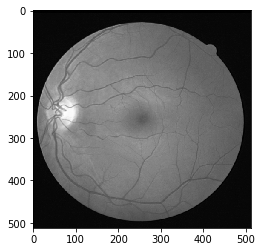

In [7]:
plt.imshow(x_test[1].reshape((512,512)), cmap = 'gray')

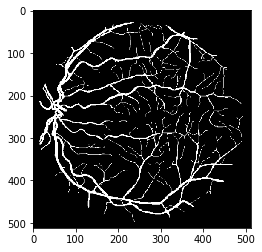

In [8]:
plt.imshow(y_test[1].reshape((512,512)), cmap = 'gray')

In [9]:
x_test[1].max(), y_test[1].max()

(1.0, 1.0)

In [0]:
smooth = 1.
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [0]:

# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers

In [0]:
def FCN_8_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,1)))
    
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
        
    model.add(Convolution2D(1024,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))
      
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(1024,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
    
    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
    
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    #print(Conv_size)
    
    model.add(Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    # O = ((I-K+2*P)/Stride)+1 
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding
    
    # I = (O-1)*Stride + K 
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512
    
    #print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)
    
    #print(Extra)
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    
    return model

In [0]:

def FCN_8(image_size):
    fcn_8 = FCN_8_helper(image_size)
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_8.layers[-1].output_shape[2] 
    
    #Conv to be applied on Pool4
    skip_con1 = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con1(fcn_8.layers[14].output),fcn_8.layers[-1].output])
    
    #Upsampling output of first skip connection
    x = Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score4")(Summed)
    x = Cropping2D(cropping=((0,2),(0,2)))(x)
    
    
    #Conv to be applied to pool3
    skip_con2 = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool3")
    
    #Adding skip connection which takes output og Max pooling layer 3 to current layer
    Summed = add(inputs = [skip_con2(fcn_8.layers[10].output),x])
    
    #Final Up convolution which restores the original image size
    Up = Deconvolution2D(21,kernel_size=(16,16),strides = (8,8),
                         padding = "valid",activation = None,name = "upsample")(Summed)
    
    #Cropping the extra part obtained due to transpose convolution
    final = Cropping2D(cropping = ((0,8),(0,8)))(Up)
    final = Convolution2D(1, 1, activation = 'sigmoid')(final)
    
    
    return Model(fcn_8.input, final)

In [15]:
model = FCN_8(512)
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 512, 1)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 512, 512, 64) 640         permute_1[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 512, 512, 64) 36928       conv1_1[0][0]                    
________________________________________________________________________________________

In [16]:
model.compile(loss='binary_crossentropy', optimizer='sgd',
                        metrics=[dice_coef, 'accuracy', precision, recall, f1score])
# optimizer=Adam(lr=1e-4)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def gene():

    data_gen_args = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        rescale=1./255,
                        fill_mode='nearest')

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1
    #image_datagen.fit(images, augment=True, seed=seed)
    #mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Training/',classes = ['original_retinal_images'],
        class_mode=None, color_mode = "grayscale", target_size = (512,512), batch_size = 5,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Training/',classes = ['blood_vessel_segmentation_masks'],
        class_mode=None, color_mode = "grayscale", target_size = (512,512), batch_size = 5,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)

    '''
    n = 1
    
    for i,j in train_generator:
        #print("n = ", n)
        n += 1
        f = plt.figure(figsize=(4, 4))
        f.add_subplot(121)
        plt.imshow(i[0].reshape((512,512)), cmap = 'gray')
        plt.axis('off')
        f.add_subplot(122)
        plt.imshow(j[0].reshape((512,512)), cmap = 'gray')
        plt.axis('off')

        plt.show(block=True)
        print(i[0].max(),j[0].max())
    '''

    return train_generator

In [18]:
myGene = gene()

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'loss',patience=5, verbose=1)

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5')

In [0]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=30,callbacks=[model_checkpoint, early_stopping], validation_data = (x_test, y_test))

Epoch 1/30





1000/1000 [==============================] - 1296s 1s/step - loss: 0.2323 - dice_coef: 0.2292 - acc: 0.8462 - precision: 0.2402 - recall: 0.1165 - f1score: nan - val_loss: 0.1285 - val_dice_coef: 0.5976 - val_acc: 0.9119 - val_precision: 0.6943 - val_recall: 0.6112 - val_f1score: 0.6496

Epoch 00001: loss improved from inf to 0.23230, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 2/30
1000/1000 [==============================] - 1267s 1s/step - loss: 0.1012 - dice_coef: 0.6524 - acc: 0.8686 - precision: 0.7219 - recall: 0.6483 - f1score: 0.6827 - val_loss: 0.1024 - val_dice_coef: 0.6708 - val_acc: 0.9193 - val_precision: 0.7657 - val_recall: 0.6534 - val_f1score: 0.7046

Epoch 00002: loss improved from 0.23230 to 0.10116, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 3/30
1000/1000 [==============================] - 1266s 1s/step - loss: 0.0883 - dice_coef: 0.6924 - acc: 0.8697 - precision: 0.7400 - recall:

In [0]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=30,callbacks=[model_checkpoint, early_stopping], validation_data = (x_test, y_test))

Epoch 1/30
1000/1000 [==============================] - 1266s 1s/step - loss: 0.0700 - dice_coef: 0.7490 - acc: 0.8706 - precision: 0.7661 - recall: 0.7443 - f1score: 0.7549 - val_loss: 0.1037 - val_dice_coef: 0.7152 - val_acc: 0.9202 - val_precision: 0.7719 - val_recall: 0.6864 - val_f1score: 0.7260

Epoch 00001: loss improved from inf to 0.07001, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 2/30
1000/1000 [==============================] - 1266s 1s/step - loss: 0.0690 - dice_coef: 0.7517 - acc: 0.8708 - precision: 0.7672 - recall: 0.7471 - f1score: 0.7569 - val_loss: 0.1048 - val_dice_coef: 0.7042 - val_acc: 0.9201 - val_precision: 0.7893 - val_recall: 0.6586 - val_f1score: 0.7174

Epoch 00002: loss improved from 0.07001 to 0.06903, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 3/30
1000/1000 [==============================] - 1265s 1s/step - loss: 0.0683 - dice_coef: 0.7541 - acc: 0.8708 - precision: 0.7682 - recall: 0

KeyboardInterrupt: ignored

In [0]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=30,callbacks=[model_checkpoint], validation_data = (x_test, y_test))

Epoch 1/30
1000/1000 [==============================] - 1265s 1s/step - loss: 0.0671 - dice_coef: 0.7578 - acc: 0.8709 - precision: 0.7695 - recall: 0.7534 - f1score: 0.7613 - val_loss: 0.1047 - val_dice_coef: 0.7167 - val_acc: 0.9202 - val_precision: 0.7702 - val_recall: 0.6901 - val_f1score: 0.7273

Epoch 00001: loss improved from 0.06771 to 0.06713, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 2/30
1000/1000 [==============================] - 1266s 1s/step - loss: 0.0668 - dice_coef: 0.7590 - acc: 0.8708 - precision: 0.7699 - recall: 0.7546 - f1score: 0.7621 - val_loss: 0.1066 - val_dice_coef: 0.7158 - val_acc: 0.9202 - val_precision: 0.7783 - val_recall: 0.6807 - val_f1score: 0.7256

Epoch 00002: loss improved from 0.06713 to 0.06679, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 3/30
1000/1000 [==============================] - 1266s 1s/step - loss: 0.0664 - dice_coef: 0.7603 - acc: 0.8708 - precision: 0.7704 - recal

In [21]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=30,callbacks=[model_checkpoint], validation_data = (x_test, y_test))



Epoch 1/30
1000/1000 [==============================] - 301s 301ms/step - loss: 0.0642 - dice_coef: 0.7673 - acc: 0.8709 - precision: 0.7726 - recall: 0.7630 - f1score: 0.7677 - val_loss: 0.1075 - val_dice_coef: 0.7189 - val_acc: 0.9201 - val_precision: 0.7721 - val_recall: 0.6882 - val_f1score: 0.7272

Epoch 00001: loss improved from inf to 0.06421, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 2/30
1000/1000 [==============================] - 290s 290ms/step - loss: 0.0639 - dice_coef: 0.7681 - acc: 0.8710 - precision: 0.7729 - recall: 0.7640 - f1score: 0.7684 - val_loss: 0.1064 - val_dice_coef: 0.7202 - val_acc: 0.9200 - val_precision: 0.7646 - val_recall: 0.6971 - val_f1score: 0.7287

Epoch 00002: loss improved from 0.06421 to 0.06390, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 3/30
1000/1000 [==============================] - 289s 289ms/step - loss: 0.0639 - dice_coef: 0.7684 - acc: 0.8709 - precision: 0.7730 - r

In [22]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=150,callbacks=[model_checkpoint], validation_data = (x_test, y_test))

Epoch 1/300
1000/1000 [==============================] - 290s 290ms/step - loss: 0.0618 - dice_coef: 0.7752 - acc: 0.8709 - precision: 0.7749 - recall: 0.7711 - f1score: 0.7729 - val_loss: 0.1073 - val_dice_coef: 0.7183 - val_acc: 0.9198 - val_precision: 0.7611 - val_recall: 0.6984 - val_f1score: 0.7278

Epoch 00001: loss did not improve from 0.06182
Epoch 2/300
1000/1000 [==============================] - 289s 289ms/step - loss: 0.0618 - dice_coef: 0.7753 - acc: 0.8709 - precision: 0.7749 - recall: 0.7712 - f1score: 0.7730 - val_loss: 0.1085 - val_dice_coef: 0.7196 - val_acc: 0.9199 - val_precision: 0.7644 - val_recall: 0.6959 - val_f1score: 0.7279

Epoch 00002: loss improved from 0.06182 to 0.06178, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 3/300
1000/1000 [==============================] - 289s 289ms/step - loss: 0.0617 - dice_coef: 0.7755 - acc: 0.8709 - precision: 0.7750 - recall: 0.7715 - f1score: 0.7732 - val_loss: 0.1091 - val_dice_coef: 0.71

KeyboardInterrupt: ignored

In [45]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=150,callbacks=[model_checkpoint], validation_data = (x_test, y_test))

Epoch 1/150
1000/1000 [==============================] - 296s 296ms/step - loss: 0.0597 - dice_coef: 0.7822 - acc: 0.8710 - precision: 0.7770 - recall: 0.7782 - f1score: 0.7776 - val_loss: 0.1126 - val_dice_coef: 0.7233 - val_acc: 0.9196 - val_precision: 0.7613 - val_recall: 0.7022 - val_f1score: 0.7298

Epoch 00001: loss improved from inf to 0.05966, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 2/150
1000/1000 [==============================] - 300s 300ms/step - loss: 0.0596 - dice_coef: 0.7825 - acc: 0.8711 - precision: 0.7772 - recall: 0.7786 - f1score: 0.7779 - val_loss: 0.1133 - val_dice_coef: 0.7244 - val_acc: 0.9196 - val_precision: 0.7622 - val_recall: 0.7025 - val_f1score: 0.7305

Epoch 00002: loss improved from 0.05966 to 0.05956, saving model to /content/drive/My Drive/Colab Notebooks/fcn_task_2.hdf5
Epoch 3/150
1000/1000 [==============================] - 294s 294ms/step - loss: 0.0596 - dice_coef: 0.7825 - acc: 0.8709 - precision: 0.7771 - 

KeyboardInterrupt: ignored

In [50]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=150,callbacks=[model_checkpoint], validation_data = (x_test, y_test))

Epoch 1/150
1000/1000 [==============================] - 287s 287ms/step - loss: 0.0670 - dice_coef: 0.7688 - acc: 0.8709 - precision: 0.7693 - recall: 0.7642 - f1score: 0.7665 - val_loss: 0.1126 - val_dice_coef: 0.7228 - val_acc: 0.9195 - val_precision: 0.7592 - val_recall: 0.7044 - val_f1score: 0.7301

Epoch 00001: loss did not improve from 0.05948
Epoch 2/150
1000/1000 [==============================] - 287s 287ms/step - loss: 0.0616 - dice_coef: 0.7760 - acc: 0.8708 - precision: 0.7735 - recall: 0.7716 - f1score: 0.7725 - val_loss: 0.1124 - val_dice_coef: 0.7224 - val_acc: 0.9196 - val_precision: 0.7607 - val_recall: 0.7028 - val_f1score: 0.7298

Epoch 00002: loss did not improve from 0.05948
Epoch 3/150
1000/1000 [==============================] - 286s 286ms/step - loss: 0.0610 - dice_coef: 0.7778 - acc: 0.8709 - precision: 0.7750 - recall: 0.7732 - f1score: 0.7740 - val_loss: 0.1114 - val_dice_coef: 0.7207 - val_acc: 0.9196 - val_precision: 0.7615 - val_recall: 0.6997 - val_f1sco

KeyboardInterrupt: ignored

In [0]:
#model.save_weights('/content/drive/My Drive/Colab Notebooks/fcn_task_2_sgd.h5')

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/fcn_task_2_sgd.h5')

In [0]:
pred = model.predict(x_test)

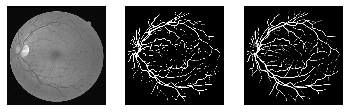

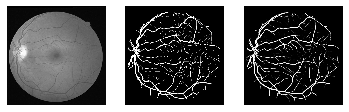

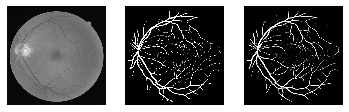

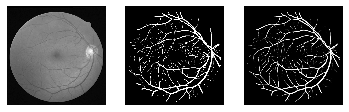

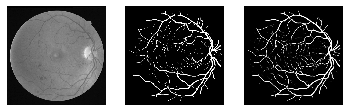

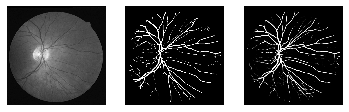

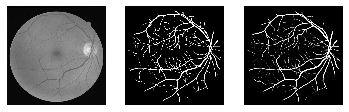

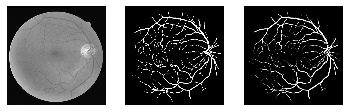

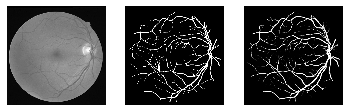

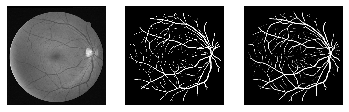

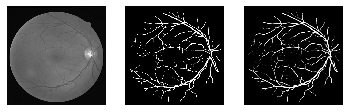

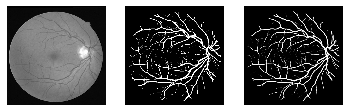

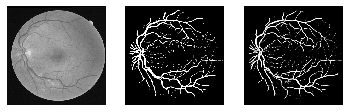

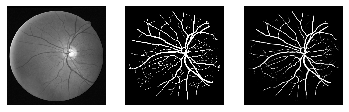

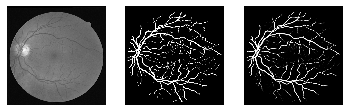

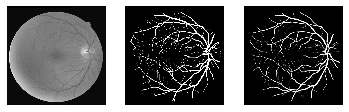

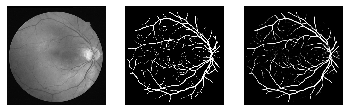

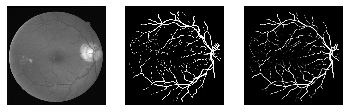

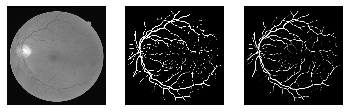

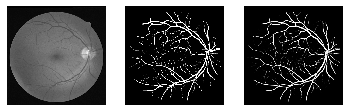

In [30]:
#save_path = "/content/drive/My Drive/Colab Notebooks/Test/fcn_prediction/"
for i in range(len(tmp)):
    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(x_test[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 2)
    plt.imshow(y_test[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 3)
    plt.imshow(pred[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    plt.show(block=True)

    #plt.imsave(save_path + f"{100+i}_ground.png", y_test[i].reshape((512,512)), cmap = 'gray')
    #plt.imsave(save_path + f"{100+i}_predict.png", tmp[i].reshape((512,512)), cmap = 'gray')